# ASTR 596: FDS Homework 5: Hunting for Exoplanets (Due April 1 at Noon)


### The Kepler satellite has discovered many multi-planet systems. You can download artwork for some of them even at the [Exoplanet Travel Bureau](https://exoplanets.nasa.gov/alien-worlds/exoplanet-travel-bureau/)

<img src="Kepler-186f_small.jpg" width="500">


### But is there a system like our own Solar system with 8 planets (sorry Pluto)? In fact, there may be at least one - [Kepler 90](https://www.nytimes.com/2017/12/14/science/eight-planets-star-system.html). This along with most other Kepler planets, were not discovered through radial velocity measurements like our example in class (i.e. that nice parameteric model doesn't apply), but were rather discovered through transits - dips in the light of the star as the planet moves around it.


<img src="Transiting-Exoplanet-Light-Curve.gif">

### You get to find 3 exoplanets in the Kepler-90 system with the techniques in class. 


### To get and analyze the Kepler data, you'll need the `lightkurve` package

> `python -m pip install lightkurve --upgrade`

### I've included some code to get the light curve, clean it and remove the NaNs, and some outliers (you can judge the wisdom of strong outlier removal when you are hunting for planets), and bin the light curve a little bit in time.


<hr>

#### Hints:


* `lightkurve` has a bunch of useful [tutorials](https://docs.lightkurve.org/index.html), in particular [this one](https://docs.lightkurve.org/tutorials/3-science-examples/periodograms-creating-periodograms.html)

* once you get to a periodogram with `lightkurve`, `find_peaks` in `scipy` can help identify the exoplanet peaks

* You might find it easier to remove the signal of each planet as you find it and work with the residual light curve to find the next. This isn't strictly necessary if you do the previous steps well, but can be helpful. The tutorials page has a demo.

* [The Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/index.html) might be of help

<hr>

# Happy (planet) hunting!

In [1]:
%matplotlib inline
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import lightkurve as lk
from scipy.signal import find_peaks

In [ ]:
### RUN THIS
lcfs = lk.search_lightcurve('Kepler-90', mission='Kepler').download_all()

In [ ]:
### RUN THIS
def squelch_rednoise(lc):
    corrected_lc = lc.remove_outliers(sigma_upper=10, sigma_lower=10).normalize().flatten(window_length=901)
    return corrected_lc

In [ ]:
### RUN THIS - it will take a while.
stitched_lc = lcfs.stitch(corrector_func=squelch_rednoise)
clc = stitched_lc.remove_nans().bin(time_bin_size=15*u.min)
clc.to_fits('corrected_lightcurve.fits', overwrite=True)

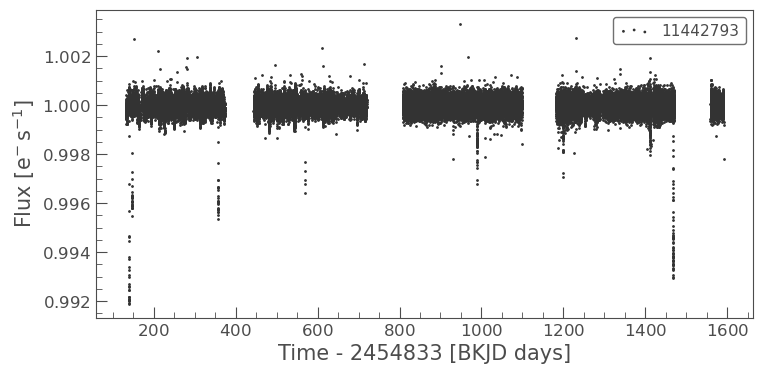

In [2]:
clc = lk.io.kepler.read_kepler_lightcurve('corrected_lightcurve.fits', quality_bitmask='none')
clc.scatter()
plt.show()

# This is the data we'll deal with

# Q1. First, calculate the periodogram using lightkurve. Use the `bls` method. Look for planets between 50 and 500 day periods with a grid spacing of 0.01d - this is coarse. Use `scipy.signal.find_peaks` to identify peaks in the periodogram. Remember to exclude any peaks arising from the Earth's revolution. Plot the periodogram and highlight the peak locations. (25 pts)


In [3]:
# YOUR CODE HERE

# First get the periodogram
period_arr = np.arange(50, 500+0.01, 0.01)
pg = clc.to_periodogram(method='bls', period=period_arr, frequency_factor=500)

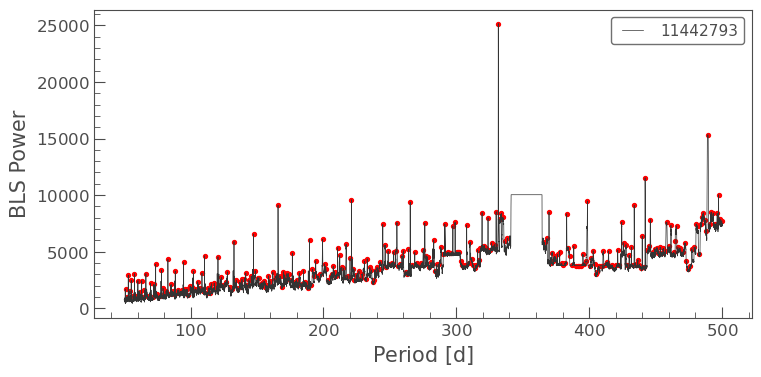

In [4]:
# Find peaks that are spaced at least 100 indices apart since there are too many peaks to be useful otherwise
# Also exclude the region around P = 1 day where the periodogram is flat
peaks = find_peaks(pg.power, distance=100)[0]
peaks = np.array([i in peaks for i in range(len(pg.period))]) & ((pg.period.value < 340) | (365.25 < pg.period.value))

period_peaks = pg.period.value[peaks]
power_peaks = pg.power.value[peaks]

pg.plot()
plt.scatter(period_peaks, power_peaks, s=8, c='Red')
plt.show()

# Q2. a. The periodogram function from lightkurve can also get a transit time and peak power using `periodogram.transit_time` and `periodogram.power` - you'll want both. Get a sorted list of candidate periods, and print it sorted by peak power. (10 pts)

In [5]:
# YOUR CODE HERE

# List the best 20 periods and the power at each period
peak_sort_inds = np.argsort(-power_peaks)
for i in range(20):
    print(f'{i+1:2}  Period: {period_peaks[peak_sort_inds][i]:.2f},  Power: {power_peaks[peak_sort_inds][i]:.2f}')

 1  Period: 331.57,  Power: 25161.14
 2  Period: 489.08,  Power: 15323.45
 3  Period: 442.09,  Power: 11530.92
 4  Period: 497.35,  Power: 10032.99
 5  Period: 221.04,  Power: 9585.03
 6  Period: 398.68,  Power: 9466.36
 7  Period: 265.26,  Power: 9381.42
 8  Period: 165.78,  Power: 9104.60
 9  Period: 433.88,  Power: 9092.94
10  Period: 329.94,  Power: 8532.56
11  Period: 369.76,  Power: 8500.54
12  Period: 491.84,  Power: 8484.37
13  Period: 319.34,  Power: 8461.95
14  Period: 485.85,  Power: 8440.18
15  Period: 493.37,  Power: 8406.69
16  Period: 496.33,  Power: 8397.48
17  Period: 333.87,  Power: 8378.21
18  Period: 383.07,  Power: 8346.61
19  Period: 484.85,  Power: 8078.03
20  Period: 335.03,  Power: 8059.43


# Q2. b. Next sort the list of periods from longest to shorted. Check if each period has a period in your list that is either 1/2 or 1/3 the same value. If it is, exclude it. If not keep it. Select the four periods with the highest power between 0 to 100d, 100d and 200d, 200d and 300d and 300d and 400d. (15 pts)

In [6]:
# YOUR CODE HERE

# Sort by period descending
power_peaks = power_peaks[np.argsort(-period_peaks)]
period_peaks = np.sort(period_peaks)[::-1]

periods_reduced, powers_reduced = [], []

# Exclude period if period/2 or period/3 are within 0.01 d of another period
for (period, power) in zip(period_peaks, power_peaks):
    if not np.any((np.abs(period_peaks - period / 2) < 0.01) | (np.abs(period_peaks - period / 3) < 0.01)):
        periods_reduced.append(period)
        powers_reduced.append(power)

periods_reduced = np.array(periods_reduced)
powers_reduced = np.array(powers_reduced)

In [7]:
# Find the period corresponding to maximum power in the period range [low, high]
# Also return the power at this period
def best_period(period, power, low, high):
    inds = (low < period) & (period < high)
    best_ind = np.argmax(power[inds])
    return period[inds][best_ind], power[inds][best_ind]

In [8]:
best_periods, best_powers = [], []

# Find the best periods within ranges 0-100, 100-200, 200-300, and 300-400
for i in range(4):
    result = best_period(periods_reduced, powers_reduced, 100 * i, 100 * (i + 1))
    best_periods.append(result[0])
    best_powers.append(result[1])

best_periods = np.array(best_periods)
best_powers = np.array(best_powers)
    
for i in range(4):
    print(f'{100 * i:3}-{100 * (i + 1)} d: Period = {best_periods[i]:6.2f} d, Power = {best_powers[i]:.4f}')

  0-100 d: Period =  82.89 d, Power = 4313.4576
100-200 d: Period = 199.33 d, Power = 6084.0672
200-300 d: Period = 299.02 d, Power = 7609.5097
300-400 d: Period = 329.94 d, Power = 8532.5561


# Q3. Select each peak period from the coarse grid in Q2.b. and then use lightkurve algorithm to refine the period within +/- 5 days, and get the best period. (25 pts)

In [9]:
# YOUR CODE HERE

# Get a better estimate of the period by searching more finely over a smaller range
# Also return the transit time for each period
def get_refined_period(lc, period, period_range):
    pg_fine = lc.to_periodogram(method='bls',
                                minimum_period=period-period_range,
                                maximum_period=period+period_range,
                                frequency_factor=1)
    return pg_fine.period_at_max_power.value, pg_fine.transit_time_at_max_power.value

refined_best_periods = []
transit_times = []

# Refine estimates of best periods in ranges 0-100, 100-200, 200-300, and 300-400
for period in best_periods:
    result = get_refined_period(clc, period, 5)
    refined_best_periods.append(result[0])
    transit_times.append(result[1])

refined_best_periods = np.array(refined_best_periods)
transit_times = np.array(transit_times)

print(' Best Periods:', refined_best_periods)
print('Transit Times:', transit_times)

 Best Periods: [ 82.89407686 199.32153857 299.02243281 331.57102149]
Transit Times: [140.54264779 140.54264779 140.54264779 140.54264779]


# Q4. Use lightkurve.fold to plot the folded light curve for each of the best periods in Q3. (25 pts)

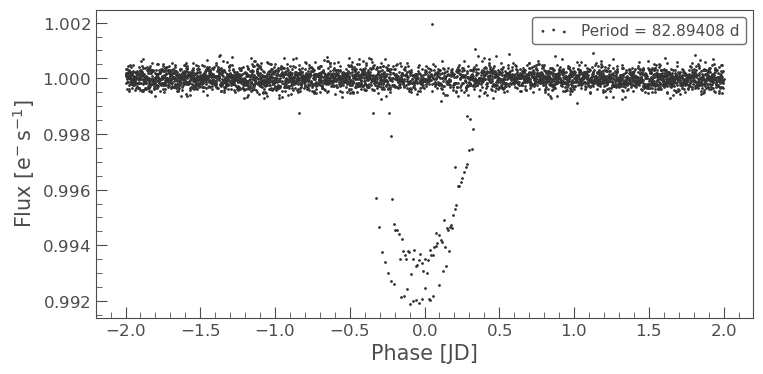

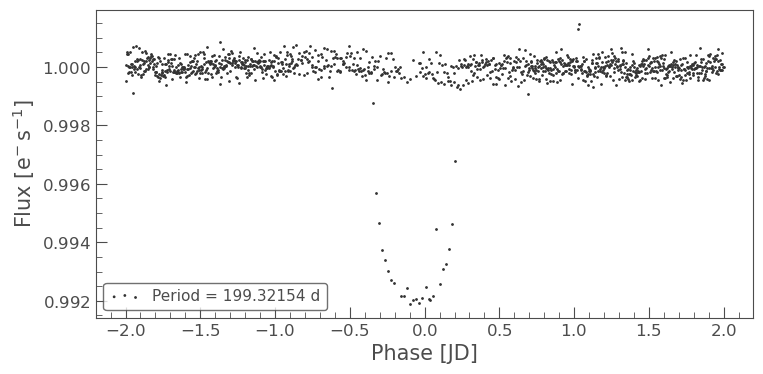

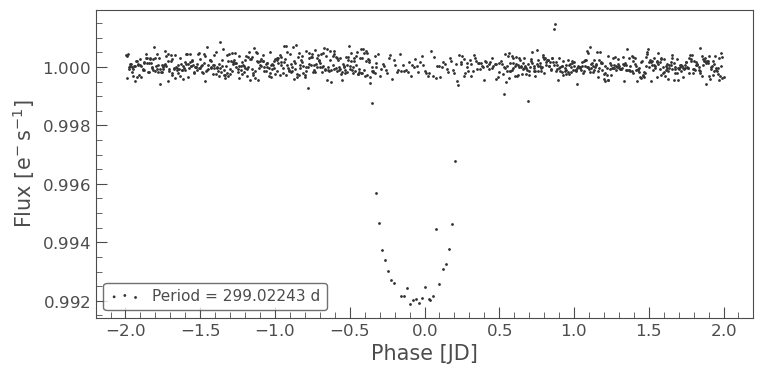

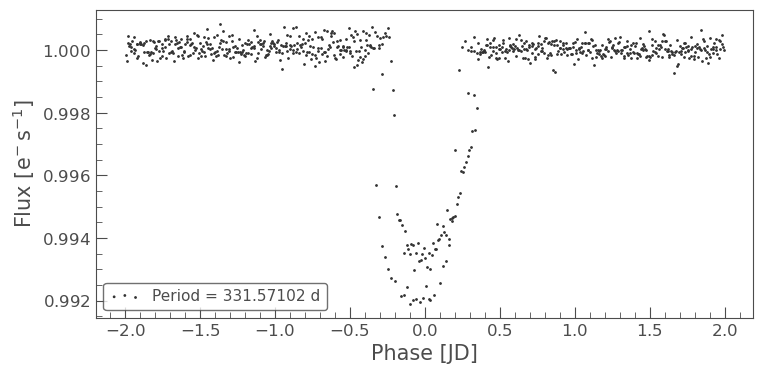

In [10]:
# YOUR CODE HERE

# Fold light curve for best periods in ranges 0-100, 100-200, 200-300, and 300-400 along with corresponding transit times
for (period, transit_time) in zip(refined_best_periods, transit_times):
    clc.fold(period, transit_time).truncate(-2, 2).scatter(label=f'Period = {period:.5f} d')
    plt.show()

We can see clear dips near a phase of 0 after folding the lightcurve for each of the four periods.